In [1]:
import sys
sys.path.insert(0, "/home/user/Projects/OrangePi")

%load_ext autoreload
%autoreload 2

from orangepi.imports import *
from orangepi.__init__ import *
from orangepi.dataset_utils import split_dataset, DeepGlobeDataset
from orangepi.model_utils import *


/home/user/Projects/OrangePi/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Выбираем модель

## Segformer-B0

In [2]:
transform = None
processor = SegformerImageProcessor.from_pretrained(
    "nvidia/segformer-b0-finetuned-ade-512-512"
)
model = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/segformer-b0-finetuned-ade-512-512",
    num_labels=NUM_CLASSES,  # Меняем количество выходных классов
    ignore_mismatched_sizes=True,  # Позволяет менять последний слой
).to(DEVICE)

model.decode_head.classifier = nn.Conv2d(256, NUM_CLASSES, kernel_size=1)
torch.nn.init.xavier_uniform_(model.decode_head.classifier.weight)
torch.nn.init.zeros_(model.decode_head.classifier.bias)

model_type = "segformer"

/home/user/Projects/OrangePi/venv/lib/python3.12/site-packages/transformers/utils/deprecation.py:172: UserWarning: The following named arguments are not valid for `SegformerImageProcessor.__init__` and were ignored: 'feature_extractor_type'
  return func(*args, **kwargs)
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([1]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([1, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Deeplab v3

In [15]:
processor = None
transform = T.Compose([T.Resize((1024, 1024)), T.ToTensor()])

model = deeplab_model()
model.classifier[4] = nn.Conv2d(256, 1, kernel_size=1)
model = model.to(DEVICE)



model_type = "deeplab"

In [3]:
# смотрим параметры модели
summary(
    model=model,
    input_size=(1, 3, 1024, 1024),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"],
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
DeepLabV3 (DeepLabV3)                                        [1, 3, 1024, 1024]   [1, 1, 1024, 1024]   --                   True
├─IntermediateLayerGetter (backbone)                         [1, 3, 1024, 1024]   [1, 960, 64, 64]     --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 1024, 1024]   [1, 16, 512, 512]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 1024, 1024]   [1, 16, 512, 512]    432                  True
│    │    └─BatchNorm2d (1)                                  [1, 16, 512, 512]    [1, 16, 512, 512]    32                   True
│    │    └─Hardswish (2)                                    [1, 16, 512, 512]    [1, 16, 512, 512]    --                   --
│    └─InvertedResidual (1)                                  [1, 16, 512, 512]    [1, 16, 512,

# Инициализируем датасет

In [11]:
# dataset_path = Path("../data/images_and_masks")
# создаем папки train, valid и test (расскоментировать при необходимости)
# dest_path = Path("../data/DeepGlobeDataset/")
# split_dataset(dataset_path, dest_path)

In [4]:
dataset_path = Path("../data/DeepGlobeDataset/")
train_dir = dataset_path / "train"
valid_dir = dataset_path / "valid"
test_dir = dataset_path / "test"

train_dataset = DeepGlobeDataset(
    train_dir, model_type, transforms=transform, processor=processor, image_size=1024
)
valid_dataset = DeepGlobeDataset(
    valid_dir, model_type, transforms=transform, processor=processor, image_size=1024
)
test_dataset = DeepGlobeDataset(
    test_dir, model_type, transforms=transform, processor=processor, image_size=1024
)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=2, shuffle=True)
test_loader  =  DataLoader(test_dataset, batch_size=2, shuffle=True)
len(train_loader), len(valid_loader), len(test_loader)

(2179, 312, 623)

### Смотрим примеры картинок с которыми работаем

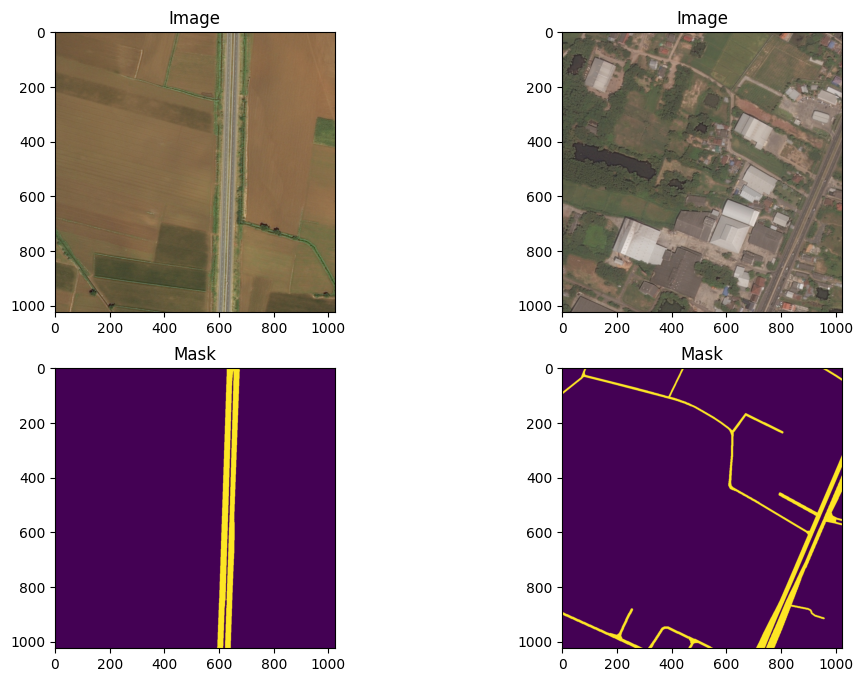

In [5]:
data = next(iter(train_loader))
num_examples = 2

fig, axes = plt.subplots(2, num_examples, figsize=(12, 8))

images, masks = data
for i in range(num_examples):
    axes[0, i].imshow(images[i].permute(1, 2, 0))
    axes[0, i].set_title("Image")
    axes[1, i].imshow(masks[i])
    axes[1, i].set_title("Mask")

# Оверфитим маленький набор данных

In [6]:
dataset_path = Path("../data/OverfittedDataset/")
train_dir = dataset_path / "train"
valid_dir = dataset_path / "valid"

train_dataset = DeepGlobeDataset(
    train_dir, model_type, transforms=transform, processor=processor, image_size=1024
)
valid_dataset = DeepGlobeDataset(
    valid_dir, model_type, transforms=transform, processor=processor, image_size=1024
)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=2, shuffle=True)

len(train_loader), len(valid_loader)

(17, 5)

# Обучение

In [7]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, pred, target):
        pred = torch.sigmoid(pred)  # Применяем сигмоиду, если pred — логиты
        intersection = (pred * target).sum()
        union = pred.sum() + target.sum()
        dice = (2.0 * intersection + self.smooth) / (union + self.smooth)
        return 1 - dice

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.8, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, pred, target):
        bce_loss = nn.functional.binary_cross_entropy_with_logits(pred, target, reduction='none')
        pt = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * bce_loss
        return focal_loss.mean()


In [ ]:
epochs = 15
# 1e-3 нормально прям было
lr = 1e-3

# Запускаем обучение
model_save_name = "DeeplabV3_DeepGlobe_V2"
assert model_save_name is not None, "Enter model's name for saving"

pos_weight = torch.tensor([100.0]).to(DEVICE)
criterions = {
    "Binary Cross Entropy": nn.BCEWithLogitsLoss(),
    "Weighted BCE Loss": nn.BCEWithLogitsLoss(pos_weight),
    "Focal Loss": FocalLoss(),
    "Dice Loss": DiceLoss()
}
criterion = criterions["Dice Loss"]

In [17]:
torch.cuda.empty_cache()
best_model, loss_history, iou_score_history, dice_history, recall_history = train(
    model,
    train_loader,
    valid_loader,
    criterion,
    lr,
    epochs,
    model_type,
    verbose=True,
    is_scheduler=True,
)
    
# --- 6. Сохранение модели ---
torch.save(best_model.state_dict(), f"../models/{model_save_name}.pth")
print("Модель сохранена!")

Initial validation loss: 0.1307
Initial validation IoU score: 0.0000
Initial validation Dice score: 0.9532
Initial validation Recall score: 0.0000
Epoch 1/15


tensor([0], device='cuda:0')
tensor([0, 1])
Train Loss: 0.0912,		Val Loss: 0.1444
Train IoU score: 0.0131,	Val IoU score: 0.0000
Train Dice score: 0.8683,	Val Dice score: 0.9522
Train Recall score: 0.0509,	Val Recall score: 0.0000
Epoch 2/15


tensor([0], device='cuda:0')
tensor([0, 1])
Train Loss: 0.0354,		Val Loss: 0.0759
Train IoU score: 0.0000,	Val IoU score: 0.0000
Train Dice score: 0.9056,	Val Dice score: 0.9532
Train Recall score: 0.0000,	Val Recall score: 0.0000
Epoch 3/15


tensor([0], device='cuda:0')
tensor([0, 1])
Train Loss: 0.0299,		Val Loss: 0.1938
Train IoU score: 0.0000,	Val IoU score: 0.0000
Train Dice score: 0.9063,	Val Dice score: 0.9532
Train Recall score: 0.0000,	Val Recall score: 0.0000
Epoch 4/15


tensor([0], device='cuda:0')
tensor([0, 1])
Train Loss: 0.0271,		Val Loss: 0.1476
Train IoU score: 0.0011,	Val IoU score: 0.0000
Train Dice score: 0.9056,	Val Dice score: 0.9532
Train Recall score: 0.0011,	Val Recall score: 0.0000
Epoch 5/15


KeyboardInterrupt: 

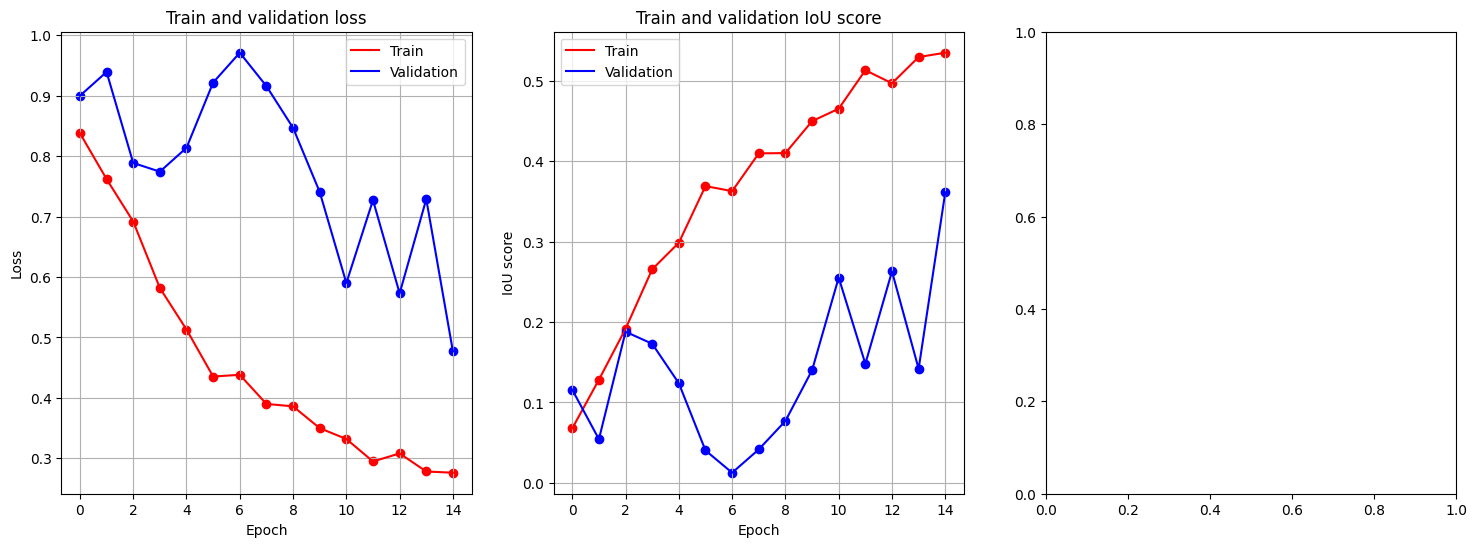

In [10]:
visualize_losses_and_scores(loss_history, iou_score_history)

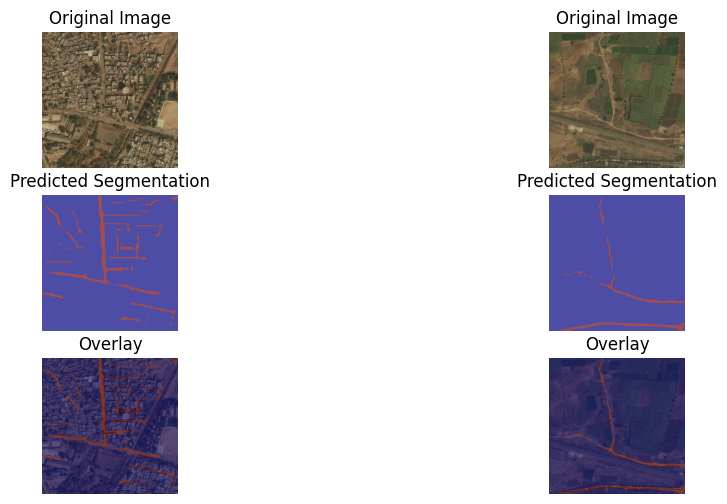

Testing:   6%|▌         | 1/17 [00:00<00:09,  1.70it/s]

Loss: 0.0030
IoU score: 0.0056
Dice score: 0.0072


In [11]:
model_path = f"../models/DeeplabV3_DeepGlobe_V1.pth"
best_model = load_model(model_path, model_type, num_classes=1)
torch.cuda.empty_cache()
test(model, train_loader, criterion, model_type, num_examples=2)

# Предсказания для батча из 1 элемента почему-то не работает, возможно из-за BatchNorma 

In [15]:
torch.cuda.empty_cache()
# Загрузка модели
model = deeplab_model()
model.classifier[4] = nn.Conv2d(256, 1, kernel_size=1)
model = model.to(DEVICE)

model_type = "deeplab"

batch_size = 2
channels = 1
height = 1024
width = 1024

# Создаем случайный тензор (имитация изображений)
input_tensor = torch.rand(batch_size, channels, height, width).to(DEVICE)

# Передача данных в модель
output = model(input_tensor)

RuntimeError: Given groups=1, weight of size [16, 3, 3, 3], expected input[2, 1, 1024, 1024] to have 3 channels, but got 1 channels instead

# Небольшие проверки

In [16]:
torch.cuda.empty_cache()

# Загрузка модели
model = deeplab_model()
model.classifier[4] = nn.Conv2d(256, 1, kernel_size=1)
model = model.to(DEVICE)

model_type = "deeplab"


input_tensor, true_mask = next(iter(valid_loader))
input_tensor = input_tensor.to(DEVICE)
true_mask = true_mask.to(DEVICE)
print(input_tensor.dtype)
print(true_mask.shape)

# input_tensor = torch.rand((2, 3, 1024, 1024)).to(DEVICE)

iou_score = JaccardIndex(
    task="binary", num_classes=1
).to(DEVICE)
# пока что Dice score только для бинарной сегментации стоит
dice_score = Dice().to(DEVICE)
recall_score = Recall(
    task="binary"
).to(DEVICE)

# Передача данных в модель
model.eval()
output = model(input_tensor)["out"]

predicted_classes = (output.squeeze(1) > 0.5).int()
print(predicted_classes.dtype)

predicted_classes = torch.zeros((2, 1024, 1024)).to(DEVICE)
true_mask = torch.ones((2, 1024, 1024)).int().to(DEVICE)

initial_val_loss = criterion(output.squeeze(1), true_mask.float()).item()
initial_val_iou_score = iou_score(predicted_classes, true_mask).detach()
initial_val_dice_score = dice_score(predicted_classes, true_mask).detach()
initial_val_recall_score = recall_score(predicted_classes, true_mask).detach()
print(initial_val_loss)
print(initial_val_iou_score)
print(initial_val_dice_score)
print(initial_val_recall_score)

torch.float32
torch.Size([2, 1024, 1024])
torch.int32
0.6675987243652344
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
